# Questions and answers
## What questions could you potentially explore/answer with this data?
* Is there a trend that ridership increases? If so, which stations see higher than average increase in ridership? This could imply an up and coming neighborhood with potential for further growth of the business's customer base. 
* Are there stations that are busier (than average) on the weekends? Stations that are busy on the weekends are more likely to be "destination" stations where people go for recreational purposes. This is especially a good thing to look for if the business is more "weekend" oriented.
* If the business is seasonal, are there stations that are busier than average in the appropriate season?
* Given demographic or other pertinent information for the stations, is the new location similar demographically to the old location? Presumably, the old location is doing well if looking to open a new location.

## Ideally, what other data would you gather or combine to learn even more?
Ideally, time of day (to decide if it is a home or work station), demographic data for the station (is it the right demographic for my business), real estate cost, competitor business data.

## How would you want to see data presented, to make it actionable by you or others?
After identifying all the metrics that are important for the business's success (e.g. neighborhood growth rate, demographic data, cost of rent, number of competitors, etc.) score the stations based on the metrics and present on a map with color coding based on the score. Hovering over the stations should produce the underlying metric information for the stations.

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [7]:
all_data = pd.read_csv("D:\\Datascope\\CTA_Ridership.csv", dtype={'station_id':'object'})
all_data.describe(include=['O'])

,station_id,stationname,date,daytype
count,809326,809326,809326,809326
unique,146,147,5691,3
top,40470,Racine,08/01/2011,W
freq,5711,5711,168,565419


In [9]:
all_data.date = pd.to_datetime(all_data.date,infer_datetime_format=True)

## Calculate general ridership trends over time

In [12]:
# dayly averages
byday = all_data.groupby(['date'])['rides'].mean().reset_index()
byday  = byday.set_index('date')

In [13]:
byday['year'] = byday.index.year
byday['month'] = byday.index.month
byday['day'] = byday.index.day

In [14]:
# monthly averages
monthly_rides = byday.groupby(['year','month']).mean()
monthly_rides.reset_index(inplace=True)
monthly_rides['date']=pd.to_datetime(monthly_rides['year'].astype(str) + '-' + monthly_rides['month'].astype(str), infer_datetime_format=True)
monthly_rides=monthly_rides.set_index('date')

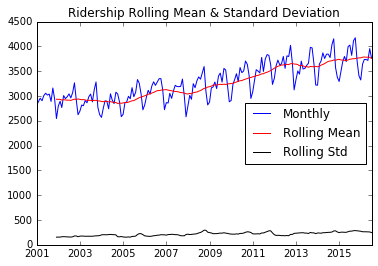

In [15]:
# plot the "L" ridership over time, calculate the rolling mean and std
rolling_mean = monthly_rides.rolling(window=12,center=False).mean()
rolling_std = monthly_rides.rolling(window=12,center=False).std()
plt.plot(monthly_rides[['rides']], color='blue', label='Monthly')
plt.plot(rolling_mean[['rides']], color='red', label='Rolling Mean')
plt.plot(rolling_std[['rides']], color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Ridership Rolling Mean & Standard Deviation')
plt.show(block=False)

Overall, the ridership increases.

Let's identify the stations with the steepest increase by calculating linear models for each of the stations. For this purpose, going back more than 5 years will unlikely result in improved performance.

In [16]:
import statsmodels.api as sm

In [18]:
# get regression lines for all stations (since 2011)
def ols_res(df, ycol):
    return sm.OLS(df[ycol], sm.add_constant(range(len(df[ycol])))).fit().params

In [20]:
all_data['year'] = all_data.date.dt.year
all_data['month'] = all_data.date.dt.month

station_ols = all_data[all_data.year > 2010].groupby(['station_id']).apply(ols_res, ycol='rides').sort_values(by=['x1'],ascending=False)

In [21]:
# Get the rate of change in ridership per day per person using the station
station_ols['daily_change_per_rider'] = station_ols['x1']/station_ols['const']

## I assume here that the business is more recreational and weekend oriented.
The following calculations are intended to identify the stations that have havier than average traffic on the weekends.

In [22]:
# weekend(holiday)/weekday per station
weekdays = all_data[(all_data.year > 2010) & (all_data.daytype == 'W')].groupby(['station_id']).mean()['rides']
weekends = all_data[(all_data.year > 2010) & (all_data.daytype != 'W')].groupby(['station_id']).mean()['rides']

In [23]:
weekdays.name = 'weekdays'
weekends.name = 'weekends'

In [24]:
weekday_analysis = pd.concat([weekdays,weekends],axis=1)
weekday_analysis['ratio'] =  weekday_analysis['weekends']/weekday_analysis['weekdays']
weekday_analysis.describe()

,weekdays,weekends,ratio
count,144.000000,144.000000,144.000000
mean,4229.483447,2282.869559,0.535938
std,3516.031043,2203.080948,0.142475
min,503.138149,256.256494,0.149506
25%,1638.032649,881.748379,0.443950
50%,3102.016366,1416.784091,0.532498
75%,5479.961666,2892.007249,0.617088
max,19694.416022,11849.746753,0.978821


In [25]:
station_data = pd.concat([station_ols,weekday_analysis],axis=1)

In [26]:
station_data = pd.concat([station_data,all_data[all_data.year > 2010][['station_id', 'stationname']].drop_duplicates('station_id').set_index('station_id')], axis=1)

In [27]:
station_data.head()

,const,x1,daily_change_per_rider,weekdays,weekends,ratio,stationname
40010,1723.846372,0.010382,0.000006,2092.652875,905.202922,0.432562,Austin-Forest Park
40020,3228.889524,0.108566,0.000034,3903.284912,2035.711039,0.521538,Harlem-Lake
40030,1891.153325,-0.222203,-0.000117,1890.245971,1142.264943,0.604294,Pulaski-Lake
40040,6013.021747,0.078009,0.000013,8033.538838,1627.383253,0.202574,Quincy/Wells
40050,3433.626727,-0.026705,-0.000008,3841.691011,2400.144481,0.624763,Davis


## Load the CTA station location data

In [28]:
stop_data = pd.read_csv("D:\\Datascope\\CTA_Stops.csv", dtype={'MAP_ID':'object'})

In [30]:
stop_data.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"


In [31]:
stop_data[['MAP_ID', 'Location']].drop_duplicates().describe(include=['O'])

,MAP_ID,Location
count,145,145
unique,144,145
top,41400,"(41.768367, -87.625724)"
freq,2,1


In [32]:
# check why the duplication for station 41400
stop_data[stop_data.MAP_ID == '41400']

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
228,30080,N,Roosevelt (Loop-Harlem-bound),Roosevelt,"Roosevelt (Red, Orange & Green Lines)",41400,True,False,False,True,False,False,False,False,False,True,"(41.867405, -87.62659)"
258,30269,N,Roosevelt (Howard-bound),Roosevelt,"Roosevelt (Red, Orange & Green Lines)",41400,True,True,False,False,False,False,False,False,False,False,"(41.867368, -87.627402)"
259,30081,S,Roosevelt (Midway-63rd-bound),Roosevelt,"Roosevelt (Red, Orange & Green Lines)",41400,True,False,False,True,False,False,False,False,False,True,"(41.867405, -87.62659)"
295,30270,S,Roosevelt (95th-bound),Roosevelt,"Roosevelt (Red, Orange & Green Lines)",41400,True,True,False,False,False,False,False,False,False,False,"(41.867368, -87.627402)"


In [33]:
# since points are very close on the map, will drop one randomly
station_data = pd.concat([station_data,stop_data[['MAP_ID', 'Location']].drop_duplicates('MAP_ID').set_index('MAP_ID')], axis=1)

In [34]:
# make separate columns for latitude and longitude
station_data['Location'] = station_data['Location'].str[1:-1].str.split(',')
lat_lons = station_data['Location'].apply(pd.Series)
lat_lons.columns = ['lat','lon']
lat_lons = lat_lons.astype('float')

In [35]:
station_data = pd.concat([station_data,lat_lons], axis=1)
station_data.drop('Location', axis=1, inplace=True)
station_data.head()

,const,x1,daily_change_per_rider,weekdays,weekends,ratio,stationname,lat,lon
40010,1723.846372,0.010382,0.000006,2092.652875,905.202922,0.432562,Austin-Forest Park,41.870851,-87.776812
40020,3228.889524,0.108566,0.000034,3903.284912,2035.711039,0.521538,Harlem-Lake,41.886848,-87.803176
40030,1891.153325,-0.222203,-0.000117,1890.245971,1142.264943,0.604294,Pulaski-Lake,41.885412,-87.725404
40040,6013.021747,0.078009,0.000013,8033.538838,1627.383253,0.202574,Quincy/Wells,41.878723,-87.633740
40050,3433.626727,-0.026705,-0.000008,3841.691011,2400.144481,0.624763,Davis,42.047710,-87.683543


# Rank the stations based on three metrics
* High growth rate of the number of riders: indicates potential for business growth
* High absolute number weekend riders: indicates good customer base for a weekend oriented business
* High ratio of the number of weekend riders to the number of weekday riders: indicates the area is a destination for recreational activity

In [36]:
weekend_rank = station_data.sort_values(by='weekends',ascending = False).index.to_series()
ratio_rank = station_data.sort_values(by='ratio',ascending = False).index.to_series()
growth_rank = station_data.sort_values(by='daily_change_per_rider',ascending = False).index.to_series()

In [37]:
weekend_rank = weekend_rank.reset_index().reset_index().drop('index',axis=1).set_index(0)
weekend_rank.columns = ['Weekend_rank']
weekend_rank['Weekend_rank'] += 1

ratio_rank = ratio_rank.reset_index().reset_index().drop('index',axis=1).set_index(0)
ratio_rank.columns = ['Ratio_rank']
ratio_rank['Ratio_rank'] += 1

growth_rank = growth_rank.reset_index().reset_index().drop('index',axis=1).set_index(0)
growth_rank.columns = ['Growth_rank']
growth_rank['Growth_rank'] += 1

In [40]:
station_ranking = pd.concat([weekend_rank,ratio_rank,growth_rank],axis=1)

## CTA stations by ridership rate growth
![growth](https://raw.githubusercontent.com/gogrmogr/CTA/master/Growth.PNG)

## CTA stations by weekend ridership
![weekend](https://raw.githubusercontent.com/gogrmogr/CTA/master/WeekendRidership.PNG)

## CTA stations by weekend to weekday ridership ratio
![ratio](https://raw.githubusercontent.com/gogrmogr/CTA/master/Ratio.PNG)

## Calculate total rank based on the sum of the three ranks above

In [41]:
station_ranking = pd.concat([station_ranking, station_ranking.sum(axis=1)], axis=1).sort_values(by=0)
station_ranking = station_ranking.reset_index().reset_index().set_index('index')
station_ranking.columns = [u'Total_rank', u'Weekend_rank', u'Ratio_rank', u'Growth_rank', 'Rank_sum']
station_ranking.head()

,Total_rank,Weekend_rank,Ratio_rank,Growth_rank,Rank_sum
index,,,,,
40330,0,3,3,12,18
40890,1,5,4,16,25
40650,2,16,9,18,43
41660,3,2,65,7,74
40100,4,32,19,29,80


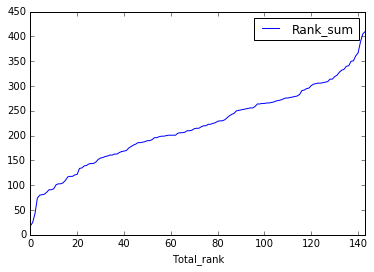

In [44]:
station_ranking.plot(x='Total_rank',y='Rank_sum')

## CTA stations total rank score (lower is better)
![ranking](https://raw.githubusercontent.com/gogrmogr/CTA/master/Ranking.PNG)

### The bright red stations are the best candidates for the new location based on the outlined criteria.